In [1]:
# maximize reproducibility: set seed with minimal imports
# just a seed
seed = 431136
import os

# verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# reproducibility
# https://github.com/NVIDIA/framework-determinism
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random

random.seed(seed)
rng_r = random.Random(seed + 1)

import numpy as np

np.random.seed(seed + 2)
rng_np = np.random.default_rng(seed + 3)

import tensorflow as tf

tf.random.set_seed(seed + 4)

In [2]:
%load_ext autoreload
%autoreload 2
from IPython.display import display

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import seaborn as sns

import pandas as pd

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# from posthoceval.explainers import KernelSHAPExplainer
# from posthoceval.explainers import MAPLEExplainer
from posthoceval.explainers import *

from posthoceval.expl_utils import standardize_effect
from posthoceval.models.gam import MultiClassLogisticGAM
from posthoceval.models.gam import LinearGAM
from posthoceval.models.gam import T
from posthoceval.models.dnn import AdditiveDNN
from posthoceval.models.cnn import AdditiveCNN
from posthoceval.transform import Transformer
from posthoceval.utils import nonexistent_filename
from posthoceval.datasets import COMPASDataset
from posthoceval.datasets import BostonDataset
from posthoceval.datasets import HELOCDataset
from posthoceval.datasets import TinyMNISTDataset
from posthoceval.models.term_util import generate_terms
from posthoceval.viz import gather_viz_data
from posthoceval import metrics

In [3]:
sns.set_theme(
    # context='paper',
    context='notebook',
    style='ticks',
    font_scale=1,  # 2.25,
    color_codes=True,
    # palette=sns.color_palette('pastel'),
)

In [4]:
def mpl_backend(backend='inline'):
    rc = plt.rcParams.copy()
    # backend = plt.get_backend()
    %matplotlib $backend
    
mpl_inline = lambda: mpl_backend('inline')
mpl_qt = lambda: mpl_backend('qt')
mpl_notebook = lambda: mpl_backend('notebook')
# valid strings are ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg',
# 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX',
# 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
# mpl_backend('nbagg')
mpl_backend('inline')

In [5]:
DEBUG = False

In [6]:
dataset_name = 'boston'

if dataset_name == 'synthetic':
    raise NotImplementedError
    task = 'regression'

    # import numpy
    # X = np.random.rand(1000, 8) / 4
    # x1, x2, x3, x4, x5, x6, x7, x8 = X.T
    # y = (x1 ** 2 + x5 ** 2 + x5 * numpy.log(x1 + x2) +
    #      x7 * numpy.select([numpy.greater(x2, numpy.sinc(x1 / numpy.pi)),
    #                         True],
    #                        [numpy.asarray(x2 ** (-1.0)).astype(numpy.bool),
    #                         numpy.asarray(numpy.sinc(x1 / numpy.pi) ** (-1.0)
    #                                       ).astype(numpy.bool)],
    #                        default=numpy.nan) + (
    #              x1 * abs(x7) + x5) ** 3 + numpy.exp(x7) + numpy.exp(
    #             (x1 + x2) / x5) + numpy.sin(numpy.log(x2)))

    # X = np.random.randn(1000, 4)
    # x1, x2, x3, x4 = X.T
    # x1 = np.abs(x1)
    # x2 = np.abs(x2)
    # y = x1 ** (1 / 4) + np.sqrt(x2) + np.exp(x3 / 2) + np.abs(x4) + np.tan(
    #     x4) / x1 ** 2

    # X = np.random.randn(1000, 2)
    # y = X[:, 0] ** 9 + np.tan(X[:, 1]) + np.abs(X[:, 0] / X[:, 1] ** 2)

    # X = np.random.randn(1000, 400)
    # y = np.exp(np.random.randn(len(X)))

    # X[:, 1] = X[:, 0] / 2
    # X[:, 2] = X[:, 1] + 1
    # X[:, 3] = X[:, 2] * 2.6
    # y = (np.sin(X[:, 0] ** 3) + np.maximum(X[:, 1], 0)
    #     - np.sin(X[:, 2]) / X[:, 2] + 2 * X[:, 3])

    feature_names = [*range(X.shape[1])]
elif dataset_name == 'compas':
    dataset_cls = COMPASDataset
elif dataset_name == 'heloc':
    dataset_cls = HELOCDataset
elif dataset_name == 'boston':
    dataset_cls = BostonDataset
elif dataset_name == 'mnist':
    dataset_cls = TinyMNISTDataset
else:
    raise NotImplementedError
    task = 'classification'
    # dataset = datasets.load_iris()
    # dataset = datasets.load_breast_cancer()
    dataset = datasets.load_wine()

    X = dataset.data
    y = dataset.target

# load dataset
dataset_orig = dataset_cls()

# transform data
transformer = Transformer()
dataset = transformer.fit_transform(dataset_orig)

# extract data
task = dataset.task
X = dataset.X
y = dataset.y
feature_names = dataset.feature_names
input_shape = dataset.input_shape
n_features = dataset.n_features

print(f'Samples     = {len(X)}')
print(f'Input Shape = {input_shape}')
print(f'Task        = {task}')

Samples     = 506
Input Shape = (13,)
Task        = regression


In [7]:
# model
if len(input_shape) > 1:
    model_type = 'cnn'
else:
    # model_type = 'gam'
    model_type = 'dnn'

In [8]:
# put together terms
max_order = 2
min_order = 1

if dataset_name == 'heloc':
    n_main = n_features - 10
    desired_interactions = [(1, 2), (10, 12), (15, 18), (7, 11)]
else:
    desired_interactions = []
    n_main = n_features

n_interact = None if desired_interactions else None

# current interact plots use this: LIME, MAPLE
# desired_interactions = [(1, 2)]

# features 8 & 9 correlate in Boston dataset
# desired_interactions = [(8, 0, 1), (2, 8), (2, 9)]

terms = generate_terms(
    n_features=n_features,
    n_main=n_main,
    n_interact=n_interact,
    desired_interactions=desired_interactions,
    min_order=min_order,
    max_order=max_order,
    seed=rng_np,
)
# terms = [T.te(0, 1), T.te(2, 3), T.s(0, n_splines=50)]
# terms = [T.te(0, 1), T.te(1, 3, n_splines=5), T.s(2, n_splines=50)]

In [9]:
if model_type == 'dnn' or model_type == 'cnn':
    callback = EarlyStopping(monitor='loss', mode='min', patience=5,
                             restore_best_weights=True)
    optimizer = Adam(learning_rate=1e-3)
    fit_kwargs = {'epochs': 1 if DEBUG else 50, 'batch_size': len(X),
                  'callbacks': [callback], 'optimizer': optimizer}
else:
    fit_kwargs = {}

# TODO: factor terms for categoricals in GAM?
# TODO: embed categoricals in NN?

if model_type == 'dnn':
    model = AdditiveDNN(
        terms=terms,
        task=task,
        symbol_names=feature_names,
        activation='relu',
    )
elif model_type == 'cnn':
    print('ignoring terms')
    model = AdditiveCNN(
        task=task,
        input_shape=input_shape,
        symbol_names=feature_names,
        activation='relu',
    )
elif model_type == 'gam':
    if task == 'classification':
        model = MultiClassLogisticGAM(symbol_names=feature_names, terms=terms)
    else:
        model = LinearGAM(symbol_names=feature_names, terms=terms)
else:
    raise NotImplementedError(model_type)

model.fit(X, y, **fit_kwargs)

if model_type == 'dnn' or model_type == 'cnn':
    model.plot_model(nonexistent_filename(f'{model_type}.png'),
                     show_shapes=True)

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 1.4877
Epoch 2/50
1/1 [==============================] - 0s 7ms/step - loss: 0.9764
Epoch 3/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6718
Epoch 4/50
1/1 [==============================] - 0s 5ms/step - loss: 0.5260
Epoch 5/50
1/1 [==============================] - 0s 5ms/step - loss: 0.4840
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 0.4958
Epoch 7/50
1/1 [==============================] - 0s 5ms/step - loss: 0.5114
Epoch 8/50
1/1 [==============================] - 0s 5ms/step - loss: 0.5069
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 10/50
1/1 [==============================] - 0s 4ms/step - loss: 0.4370
Epoch 11/50
1/1 [==============================] - 0s 4ms/step - loss: 0.3891
Epoch 12/50
1/1 [==============================] - 0s 4ms/step - loss: 0.3428
Epoch 13/50
1/1 [==============================] - 0s 4ms/step - loss: 0.3

In [10]:
explain_only_this_many = 10 if DEBUG else min(len(X), 250)

explain_only_this_many = min(explain_only_this_many, len(X))
sample_idxs_all = np.arange(len(X))
sample_idxs = rng_np.choice(sample_idxs_all,
                            size=explain_only_this_many, replace=False)
X_subset = X[sample_idxs]
y_subset = y[sample_idxs]

true_contribs = model.feature_contributions(X_subset)

In [11]:
explainer_array = [
    #('VanillaGradients', VanillaGradientsExplainer),
    #('VanillaGradients-Smooth', VanillaGradientsExplainer.smooth_grad),
    #('GradientsXInputs', GradientsXInputsExplainer),
    #('GradientsXInputs-Smooth', GradientsXInputsExplainer.smooth_grad),
    #('IntegratedGradients', IntegratedGradientsExplainer),
    #('IntegratedGradients-Smooth', IntegratedGradientsExplainer.smooth_grad),
    #('Occlusion', OcclusionExplainer),
    #('XRAI', XRAIExplainer),
    #('XRAI-Smooth', XRAIExplainer.smooth_grad),
    #('BlurIG', BlurIntegratedGradientsExplainer),
    #('BlurIG-Smooth', BlurIntegratedGradientsExplainer.smooth_grad),
    ('LIME', LIMEExplainer),
    ('SHAP', KernelSHAPExplainer),
    ('SHAPR', SHAPRExplainer),
]
if task == 'regression':
    explainer_array.extend([
        ('MAPLE', MAPLEExplainer),
        ('PDP', PDPExplainer),
    ])

# TODO: feature_contributions() --> explain()
# TODO: explain() --> ExplainerMixin (for both models and explainers)

pred_contribs_map = {}
pred_y_map = {}

In [12]:
# import os
# os.environ['R_HOME'] = '/afs/crc.nd.edu/x86_64_linux/r/R/3.6.2/gcc/4.8.5/bin/R'
# del os.environ['R_HOME']
# import sys
# sys.path.append('/afs/crc.nd.edu/x86_64_linux/r/R/3.6.2/gcc/4.8.5/bin/')

for expl_i, (explainer_name, explainer_cls) in enumerate(explainer_array):
    if explainer_name in pred_contribs_map:
        print('Skipping', explainer_name)
        continue
    print('Explaining model using', explainer_name)
    explainer = explainer_cls(model, seed=seed, task=task)
    explainer.fit(dataset)  # fit full dataset
    pred_contribs, y_pred = explainer.feature_contributions(
        X_subset, as_dict=True, return_predictions=True)

    # store for later viz data generation
    pred_contribs_map[explainer_name] = pred_contribs
    pred_y_map[explainer_name] = y_pred

Explaining model using LIME
Explaining model using SHAP


Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


  0%|          | 0/250 [00:00<?, ?it/s]

Explaining model using SHAPR
Explaining model using MAPLE
Explaining model using PDP


In [13]:
# TODO: import from viz and implement fully...
# plot_fit()

df, df_3d, contribs_df, err_dfs = gather_viz_data(
    model=model,
    dataset=dataset,
    transformer=transformer,
    true_contribs=true_contribs,
    pred_contribs_map=pred_contribs_map,
    dataset_sample_idxs=sample_idxs,
)

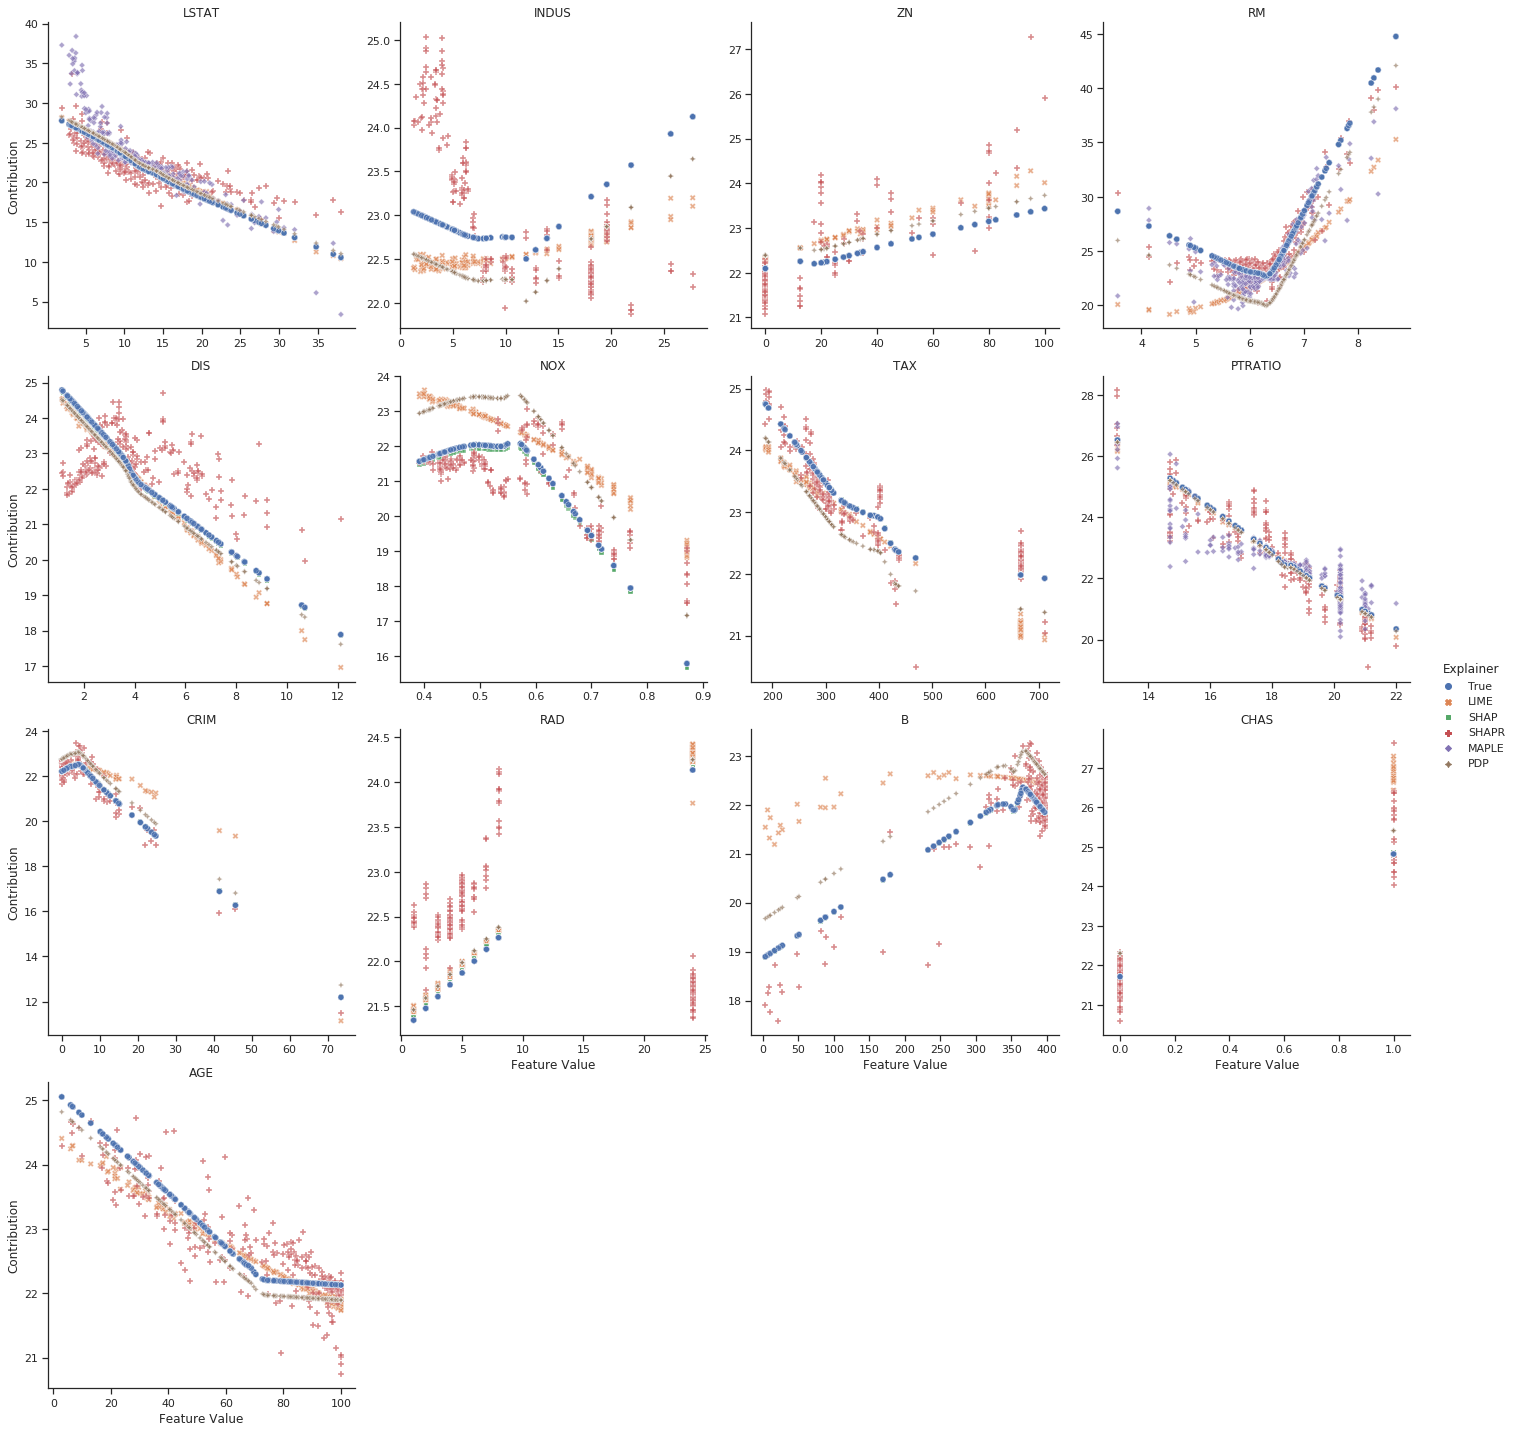

In [14]:
col_wrap = 4

if df is not None:
    # from seaborn._core import unique_markers
    
    # if n_features > 12 or task == 'classification':
    #     mpl_qt()
    # else:
    #     mpl_inline()
    g = sns.relplot(
        data=df,
        x='Feature Value',
        y='Contribution',
        hue='Explainer',
        style='Explainer',
        # markers=unique_markers(len(explainer_array) + 1),
        # col='class' if task == 'classification' else 'true_effect',
        col='Class' if task == 'classification' else 'Match',
        col_wrap=None if task == 'classification' else col_wrap,
        # row='true_effect' if task == 'classification' else None,
        row='Match' if task == 'classification' else None,
        kind='scatter',
        x_jitter=.08,  # for visualization purposes of nearby points
        # scatter_kws=dict(alpha=.65),
        alpha=.65,
        facet_kws=dict(sharex=False, sharey=False),
        # sharex=False, sharey=False
    )
    for ax in g.axes.flat:
        title = ax.get_title()
        ax.set_title(title.split(' = ', 1)[1])
    g.tight_layout()
    g.savefig(nonexistent_filename(f'contributions_grid_{model_type}.pdf'))

In [15]:
# 3d interaction plot time
if df_3d is not None:

    plt_x = 'Feature Value x'
    plt_y = 'Feature Value y'
    plt_z = 'Contribution'
    plt_hue = 'Explainer'
    plt_col = 'Match'

    df_3d_grouped = df_3d.groupby(['Class', plt_col])

    n_plots = len(df_3d_grouped)
    n_rows = int(np.ceil(n_plots / col_wrap))
    n_cols = min(col_wrap, n_plots)
    figsize = plt.rcParams['figure.figsize']
    figsize = (figsize[0] * n_cols, figsize[1] * n_rows)
    fig = plt.figure(figsize=figsize)

    for i, ((class_i, ax_title), group_3d) in enumerate(df_3d_grouped):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='3d')

        for hue_name, hue_df in group_3d.groupby(plt_hue):
            ax.scatter(
                hue_df[plt_x],
                hue_df[plt_y],
                hue_df[plt_z],
                label=hue_name,
                alpha=.5,
            )
        ax.set_xlabel(plt_x)
        ax.set_ylabel(plt_y)
        ax.set_zlabel(plt_z)

        ax.set_title(ax_title)

        if i == 0:
            fig.legend(loc='center right')
    fig.tight_layout()
    fig.savefig(nonexistent_filename(
        f'contributions_grid_interact_{model_type}.pdf'))

In [16]:
err_dfs['effectwise_err_agg']

,Explainer,Class,Metric,Score
0,LIME,MEDV,mean_absolute_percentage_error,7.928466e-01
1,LIME,MEDV,normalized_root_mean_squared_error__normalize_...,2.687582e+13
2,LIME,MEDV,normalized_root_mean_squared_error__normalize_...,1.395592e-01
3,LIME,MEDV,pearson_correlation_coef,9.471259e-01
4,LIME,MEDV,root_mean_squared_error,7.623392e-02
5,LIME,MEDV,spearman_rank_correlation,7.036808e-01
6,SHAP,MEDV,mean_absolute_percentage_error,6.533462e-02
7,SHAP,MEDV,normalized_root_mean_squared_error__normalize_...,1.734948e+12
8,SHAP,MEDV,normalized_root_mean_squared_error__normalize_...,5.744849e-03
9,SHAP,MEDV,pearson_correlation_coef,1.000000e+00


In [17]:
err_dfs['samplewise_err_agg']

,Explainer,Class,Metric,Score
0,LIME,MEDV,cosine_distances,0.189360
1,LIME,MEDV,euclidean_distances,0.349338
2,SHAP,MEDV,cosine_distances,0.000577
3,SHAP,MEDV,euclidean_distances,0.015572
4,SHAPR,MEDV,cosine_distances,0.216312
5,SHAPR,MEDV,euclidean_distances,0.373728
6,MAPLE,MEDV,cosine_distances,0.433949
7,MAPLE,MEDV,euclidean_distances,0.490579
8,PDP,MEDV,cosine_distances,0.293303
9,PDP,MEDV,euclidean_distances,0.366188


In [18]:
def combine_effects(*effect_sets):
    all_effects = []
    for effects_set in zip(*effect_sets):
        features = set()
        for effects in effects_set:
            for effect in effects:
                features.update(effect)
        all_effects.append(standardize_effect(tuple(features)))
    return all_effects


def effects_to_str(*effect_sets):
    effect_strs = []
    for effects_set in zip(*effect_sets):
        features = set()
        for effects in effects_set:
            for effect in effects:
                features.update(effect)
        features = ' & '.join(standardize_effect(tuple(features)))
        effect_strs.append(features)
    return effect_strs


def grab_expl_data(explanation):
    contribs = contribs_df[(contribs_df['Explainer'] == explanation['Explainer']) &
                           (contribs_df['Class'] == explanation['Class'])]
    assert len(contribs) == 1
    # get contribs for true/pred
    contribs = contribs.iloc[0]
    true_contribs = contribs['True Contribs']
    pred_contribs = contribs['Pred Contribs']
    # get attributions for effects
    sample_idx = explanation['Sample Index']
    # pred
    sample_pred_contribs = pred_contribs.iloc[sample_idx]
    pred_effects = sample_pred_contribs.keys()
    pred_contribs = sample_pred_contribs.values
    # true
    sample_true_contribs = true_contribs.iloc[sample_idx]
    true_effects = sample_true_contribs.keys()
    true_contribs = sample_true_contribs.values
    return pred_effects, pred_contribs, true_effects, true_contribs, sample_idx


def plot_explanation(
    explanation,
    k=10,
):
    pred_effects, pred_contribs, true_effects, true_contribs, _ = grab_expl_data(explanation)
    # map to readable strings
    all_effects = effects_to_str(pred_effects, true_effects)
    # grab top-k effects
    sort_idx = np.argsort(np.abs(true_contribs))[-k:][::-1]
    pred_contribs = pred_contribs[sort_idx]
    true_contribs = true_contribs[sort_idx]
    all_effects = np.asarray(all_effects)[sort_idx]
    # set up DF for plotting
    df_plot = pd.concat([
        pd.DataFrame({
            'Effect': all_effects,
            'Explainer': 'True',
            'Contribution': true_contribs,
        }),
        pd.DataFrame({
            'Effect': all_effects,
            'Explainer': explanation['Explainer'],
            'Contribution': pred_contribs,
        }),
    ], ignore_index=True)
    f, ax = plt.subplots()
    sns.barplot(y='Effect', x='Contribution', hue='Explainer',
                data=df_plot, ax=ax,
                orient='h')
    # ax.set_xscale('symlog')
    f.tight_layout()
    return ax


def heatmap_explanation(
    explanation,
    shape,
):
    pred_effects, pred_contribs, true_effects, true_contribs, sample_idx = grab_expl_data(explanation)
    all_effects = combine_effects(pred_effects, true_effects)
    viz_data_true = np.zeros(n_features)
    viz_data = np.zeros(n_features)
    for j, effect in enumerate(all_effects):
        idxs = [model.symbols.index(feat) for feat in effect]
        viz_data[idxs] = pred_contribs[j]
        viz_data_true[idxs] = true_contribs[j]

    viz_data_true = viz_data_true.reshape(shape)
    viz_data = viz_data.reshape(shape)
    
    f, ax = plt.subplots(1, 3)
    ax = ax.flatten()
    sns.heatmap(X_subset[sample_idx].squeeze(), ax=ax[0], cmap='gray',
                square=True)
    ax[0].set_title('Data')
    
    # f, ax = plt.subplots()
    sns.heatmap(viz_data_true, ax=ax[1], cmap='coolwarm', square=True)
    ax[1].set_title('True')
    
    # f, ax = plt.subplots()
    sns.heatmap(viz_data, ax=ax[2], cmap='coolwarm', square=True)
    ax[2].set_title('Explainer')
    
    f.tight_layout()
    return f

In [19]:
k = 5
worst_by = 'root_mean_squared_error'

# Top k worst effects per explainer
df_effects = err_dfs['effectwise_err']
df_effects = df_effects[df_effects['Metric'] == worst_by]
for explainer_name, df_expl_effects in df_effects.groupby(['Explainer']):
    k_f = min(k, len(df_expl_effects))
    df_expl_effects = df_expl_effects.sort_values(by='Score', ascending=False)
    print(f'{explainer_name} Top-{k_f} worst effects:')
    display(df_expl_effects.iloc[:k_f])
    print(f'{explainer_name} Top-{k_f} best effects:')
    display(df_expl_effects.iloc[-k_f:])

LIME Top-5 worst effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
18,root_mean_squared_error,0.312483,LIME,MEDV,"((RM,),)","((RM,),)"
30,root_mean_squared_error,0.157099,LIME,MEDV,"((NOX,),)","((NOX,),)"
60,root_mean_squared_error,0.090039,LIME,MEDV,"((B,),)","((B,),)"
66,root_mean_squared_error,0.077579,LIME,MEDV,"((CHAS,),)","((CHAS,),)"
0,root_mean_squared_error,0.065443,LIME,MEDV,"((LSTAT,),)","((LSTAT,),)"


LIME Top-5 best effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
12,root_mean_squared_error,0.034276,LIME,MEDV,"((ZN,),)","((ZN,),)"
24,root_mean_squared_error,0.031265,LIME,MEDV,"((DIS,),)","((DIS,),)"
72,root_mean_squared_error,0.028423,LIME,MEDV,"((AGE,),)","((AGE,),)"
54,root_mean_squared_error,0.014079,LIME,MEDV,"((RAD,),)","((RAD,),)"
42,root_mean_squared_error,0.009125,LIME,MEDV,"((PTRATIO,),)","((PTRATIO,),)"


MAPLE Top-5 worst effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
234,root_mean_squared_error,0.302602,MAPLE,MEDV,"((LSTAT,),)","((LSTAT,),)"
264,root_mean_squared_error,0.231204,MAPLE,MEDV,"((NOX,),)",()
252,root_mean_squared_error,0.214182,MAPLE,MEDV,"((RM,),)","((RM,),)"
258,root_mean_squared_error,0.158335,MAPLE,MEDV,"((DIS,),)",()
282,root_mean_squared_error,0.116439,MAPLE,MEDV,"((CRIM,),)",()


MAPLE Top-5 best effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
270,root_mean_squared_error,0.109481,MAPLE,MEDV,"((TAX,),)",()
306,root_mean_squared_error,0.090703,MAPLE,MEDV,"((AGE,),)",()
276,root_mean_squared_error,0.072283,MAPLE,MEDV,"((PTRATIO,),)","((PTRATIO,),)"
240,root_mean_squared_error,0.058399,MAPLE,MEDV,"((INDUS,),)",()
246,root_mean_squared_error,0.046149,MAPLE,MEDV,"((ZN,),)",()


PDP Top-5 worst effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
330,root_mean_squared_error,0.291726,PDP,MEDV,"((RM,),)","((RM,),)"
342,root_mean_squared_error,0.149679,PDP,MEDV,"((NOX,),)","((NOX,),)"
372,root_mean_squared_error,0.084772,PDP,MEDV,"((B,),)","((B,),)"
378,root_mean_squared_error,0.064390,PDP,MEDV,"((CHAS,),)","((CHAS,),)"
348,root_mean_squared_error,0.059994,PDP,MEDV,"((TAX,),)","((TAX,),)"


PDP Top-5 best effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
324,root_mean_squared_error,0.032297,PDP,MEDV,"((ZN,),)","((ZN,),)"
336,root_mean_squared_error,0.029602,PDP,MEDV,"((DIS,),)","((DIS,),)"
384,root_mean_squared_error,0.025436,PDP,MEDV,"((AGE,),)","((AGE,),)"
366,root_mean_squared_error,0.012585,PDP,MEDV,"((RAD,),)","((RAD,),)"
354,root_mean_squared_error,0.007731,PDP,MEDV,"((PTRATIO,),)","((PTRATIO,),)"


SHAP Top-5 worst effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
108,root_mean_squared_error,0.012082,SHAP,MEDV,"((NOX,),)","((NOX,),)"
144,root_mean_squared_error,0.005008,SHAP,MEDV,"((CHAS,),)","((CHAS,),)"
126,root_mean_squared_error,0.004956,SHAP,MEDV,"((CRIM,),)","((CRIM,),)"
102,root_mean_squared_error,0.004798,SHAP,MEDV,"((DIS,),)","((DIS,),)"
132,root_mean_squared_error,0.003455,SHAP,MEDV,"((RAD,),)","((RAD,),)"


SHAP Top-5 best effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
96,root_mean_squared_error,0.000591,SHAP,MEDV,"((RM,),)","((RM,),)"
120,root_mean_squared_error,0.000578,SHAP,MEDV,"((PTRATIO,),)","((PTRATIO,),)"
90,root_mean_squared_error,0.000408,SHAP,MEDV,"((ZN,),)","((ZN,),)"
150,root_mean_squared_error,0.000321,SHAP,MEDV,"((AGE,),)","((AGE,),)"
84,root_mean_squared_error,0.000305,SHAP,MEDV,"((INDUS,),)","((INDUS,),)"


SHAPR Top-5 worst effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
156,root_mean_squared_error,0.222828,SHAPR,MEDV,"((LSTAT,),)","((LSTAT,),)"
210,root_mean_squared_error,0.163740,SHAPR,MEDV,"((RAD,),)","((RAD,),)"
180,root_mean_squared_error,0.157581,SHAPR,MEDV,"((DIS,),)","((DIS,),)"
174,root_mean_squared_error,0.131546,SHAPR,MEDV,"((RM,),)","((RM,),)"
162,root_mean_squared_error,0.103097,SHAPR,MEDV,"((INDUS,),)","((INDUS,),)"


SHAPR Top-5 best effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
216,root_mean_squared_error,0.051712,SHAPR,MEDV,"((B,),)","((B,),)"
228,root_mean_squared_error,0.048889,SHAPR,MEDV,"((AGE,),)","((AGE,),)"
222,root_mean_squared_error,0.043453,SHAPR,MEDV,"((CHAS,),)","((CHAS,),)"
192,root_mean_squared_error,0.034894,SHAPR,MEDV,"((TAX,),)","((TAX,),)"
204,root_mean_squared_error,0.033107,SHAPR,MEDV,"((CRIM,),)","((CRIM,),)"


LIME Top-5 worst explanations:


,Metric,Score,Explainer,Class,Sample Index
70,cosine_distances,1.047428,LIME,MEDV,70
2,cosine_distances,0.896287,LIME,MEDV,2
208,cosine_distances,0.895851,LIME,MEDV,208
42,cosine_distances,0.863381,LIME,MEDV,42
89,cosine_distances,0.840583,LIME,MEDV,89


LIME Top-5 best explanations:


,Metric,Score,Explainer,Class,Sample Index
90,cosine_distances,0.042100,LIME,MEDV,90
165,cosine_distances,0.040606,LIME,MEDV,165
222,cosine_distances,0.024648,LIME,MEDV,222
213,cosine_distances,0.019790,LIME,MEDV,213
183,cosine_distances,0.016648,LIME,MEDV,183


MAPLE Top-5 worst explanations:


,Metric,Score,Explainer,Class,Sample Index
1570,cosine_distances,1.517292,MAPLE,MEDV,70
1542,cosine_distances,1.425524,MAPLE,MEDV,42
1656,cosine_distances,1.404541,MAPLE,MEDV,156
1611,cosine_distances,1.313202,MAPLE,MEDV,111
1702,cosine_distances,1.306014,MAPLE,MEDV,202


MAPLE Top-5 best explanations:


,Metric,Score,Explainer,Class,Sample Index
1567,cosine_distances,0.047565,MAPLE,MEDV,67
1704,cosine_distances,0.044198,MAPLE,MEDV,204
1713,cosine_distances,0.037740,MAPLE,MEDV,213
1530,cosine_distances,0.035662,MAPLE,MEDV,30
1671,cosine_distances,0.033775,MAPLE,MEDV,171


PDP Top-5 worst explanations:


,Metric,Score,Explainer,Class,Sample Index
2070,cosine_distances,1.228657,PDP,MEDV,70
2093,cosine_distances,1.186483,PDP,MEDV,93
2191,cosine_distances,1.118762,PDP,MEDV,191
2202,cosine_distances,1.099468,PDP,MEDV,202
2042,cosine_distances,1.031860,PDP,MEDV,42


PDP Top-5 best explanations:


,Metric,Score,Explainer,Class,Sample Index
2226,cosine_distances,0.013909,PDP,MEDV,226
2222,cosine_distances,0.008692,PDP,MEDV,222
2139,cosine_distances,0.007788,PDP,MEDV,139
2213,cosine_distances,0.007394,PDP,MEDV,213
2183,cosine_distances,0.004550,PDP,MEDV,183


SHAP Top-5 worst explanations:


,Metric,Score,Explainer,Class,Sample Index
708,cosine_distances,0.003624,SHAP,MEDV,208
691,cosine_distances,0.003275,SHAP,MEDV,191
593,cosine_distances,0.003075,SHAP,MEDV,93
630,cosine_distances,0.002714,SHAP,MEDV,130
539,cosine_distances,0.002693,SHAP,MEDV,39


SHAP Top-5 best explanations:


,Metric,Score,Explainer,Class,Sample Index
726,cosine_distances,0.000043,SHAP,MEDV,226
722,cosine_distances,0.000030,SHAP,MEDV,222
713,cosine_distances,0.000028,SHAP,MEDV,213
639,cosine_distances,0.000025,SHAP,MEDV,139
683,cosine_distances,0.000019,SHAP,MEDV,183


SHAPR Top-5 worst explanations:


,Metric,Score,Explainer,Class,Sample Index
1212,cosine_distances,0.849135,SHAPR,MEDV,212
1032,cosine_distances,0.763735,SHAPR,MEDV,32
1152,cosine_distances,0.721889,SHAPR,MEDV,152
1174,cosine_distances,0.665576,SHAPR,MEDV,174
1053,cosine_distances,0.653929,SHAPR,MEDV,53


SHAPR Top-5 best explanations:


,Metric,Score,Explainer,Class,Sample Index
1083,cosine_distances,0.020898,SHAPR,MEDV,83
1183,cosine_distances,0.016839,SHAPR,MEDV,183
1165,cosine_distances,0.014038,SHAPR,MEDV,165
1139,cosine_distances,0.012588,SHAPR,MEDV,139
1222,cosine_distances,0.009886,SHAPR,MEDV,222


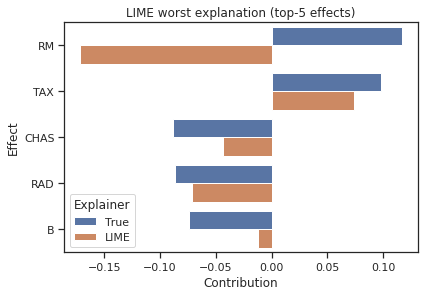

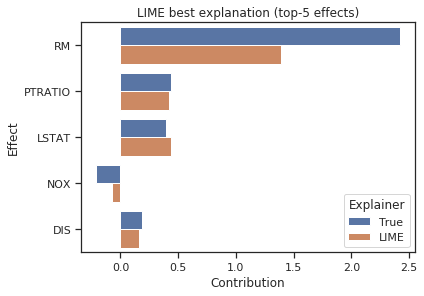

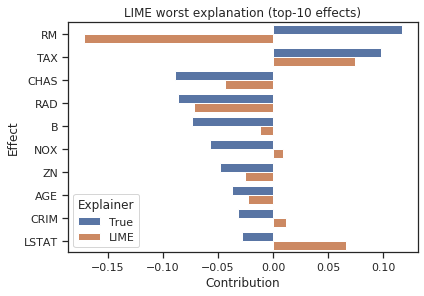

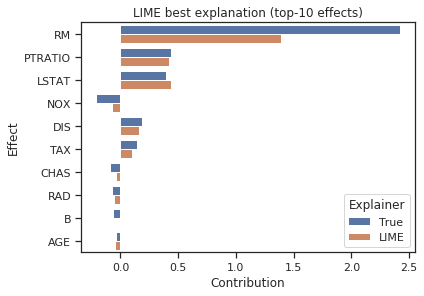

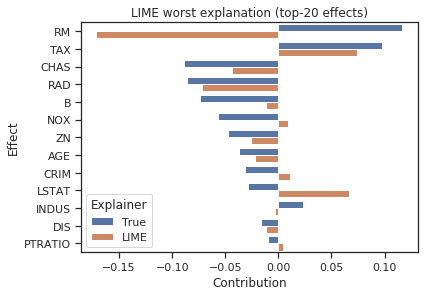

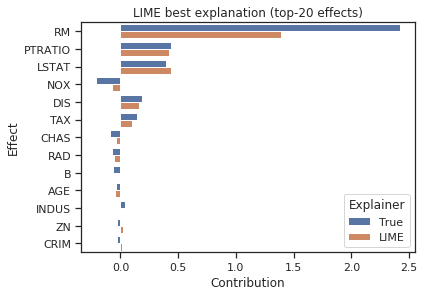

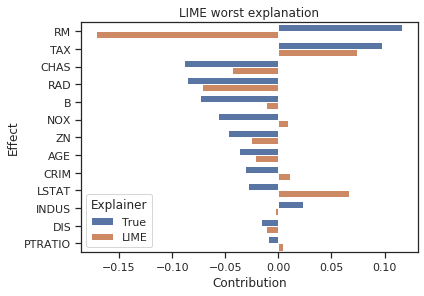

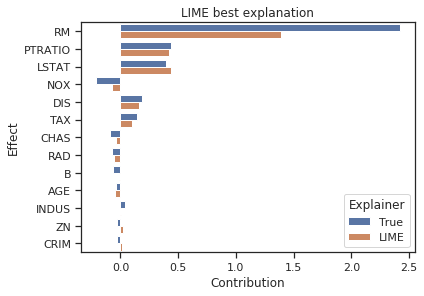

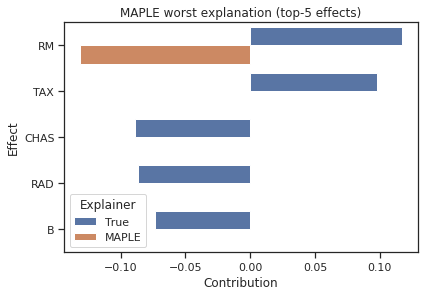

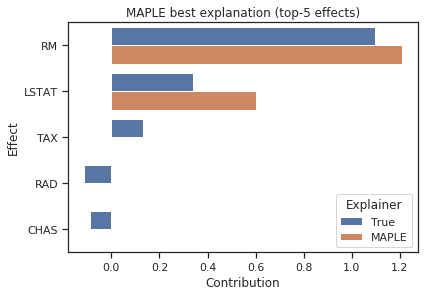

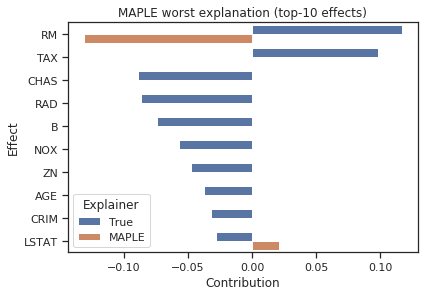

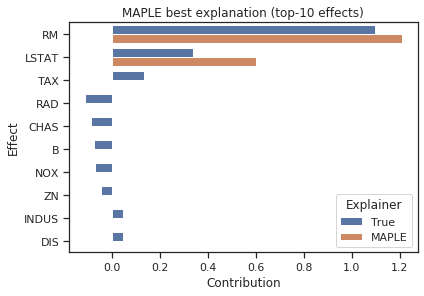

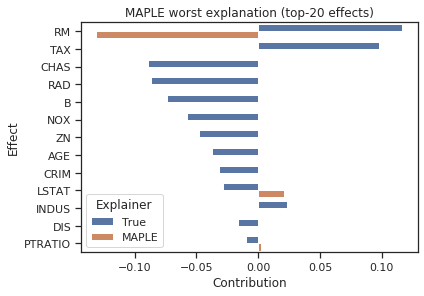

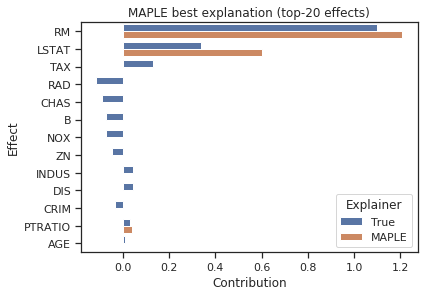

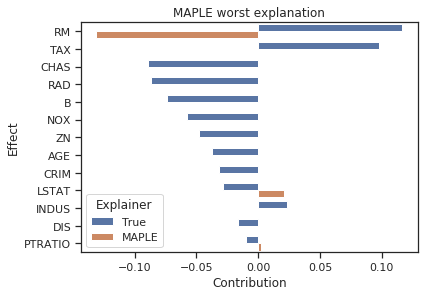

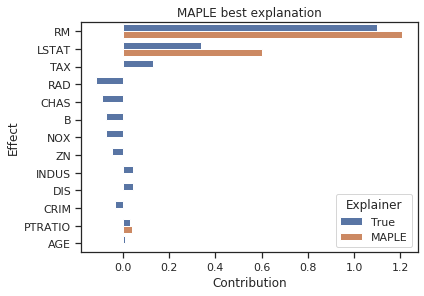

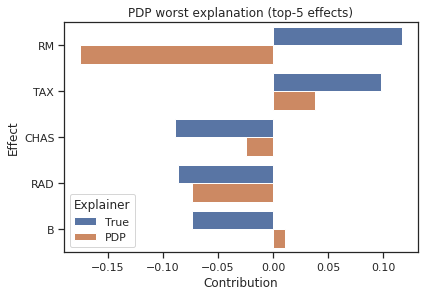

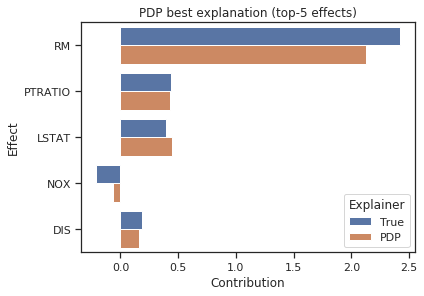

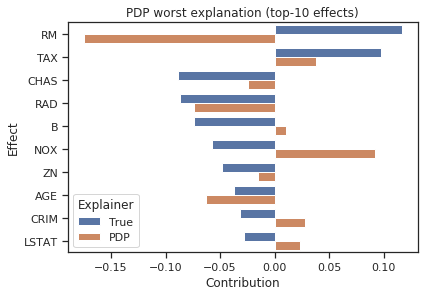

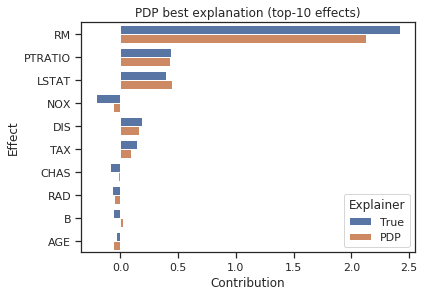

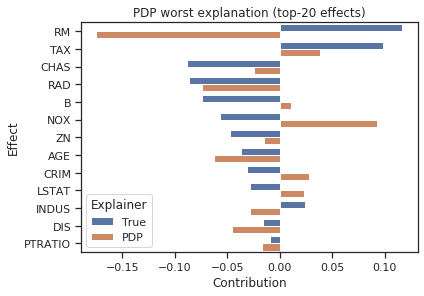

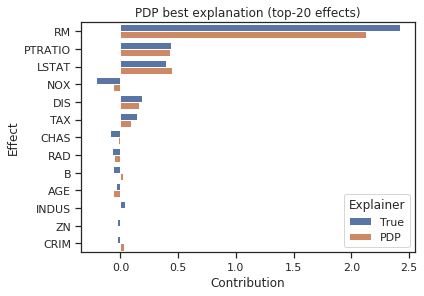

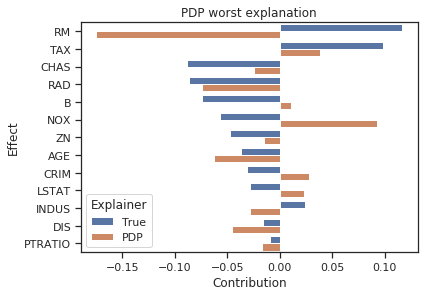

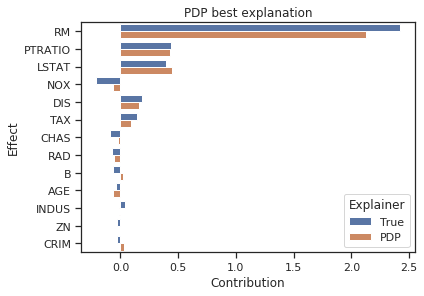

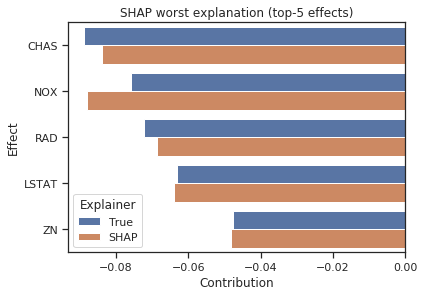

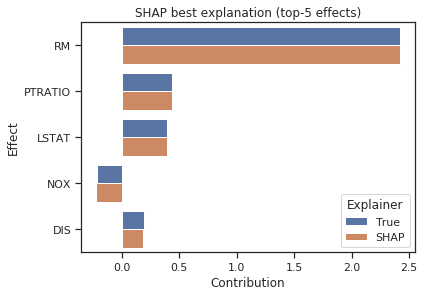

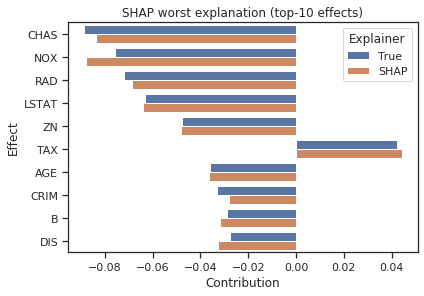

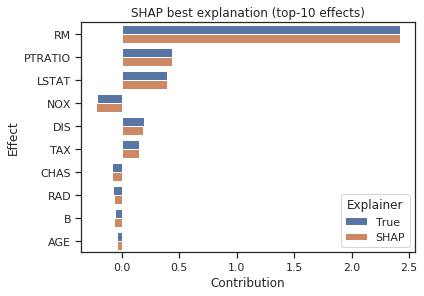

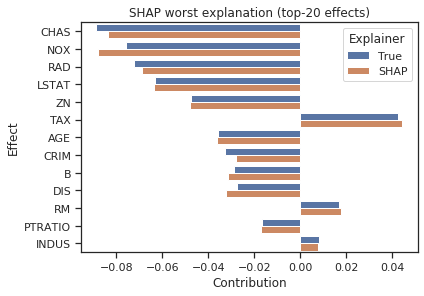

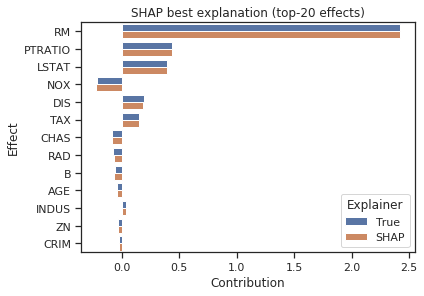

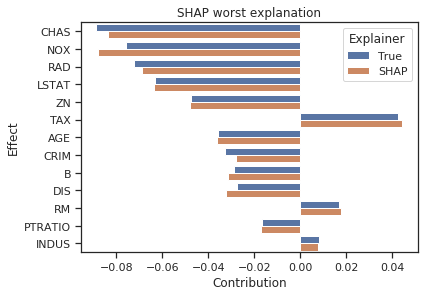

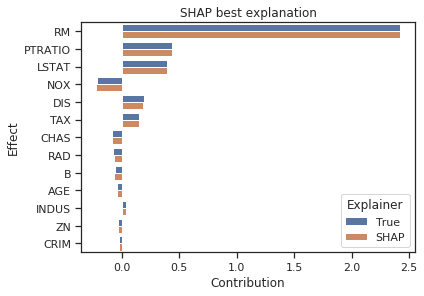

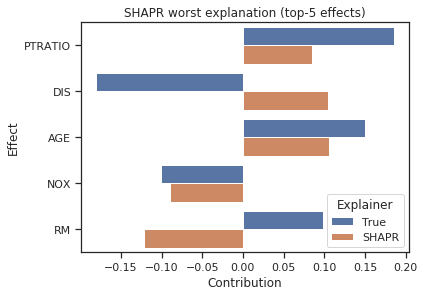

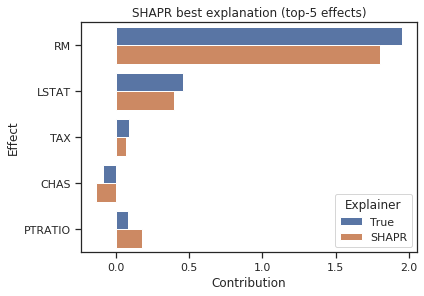

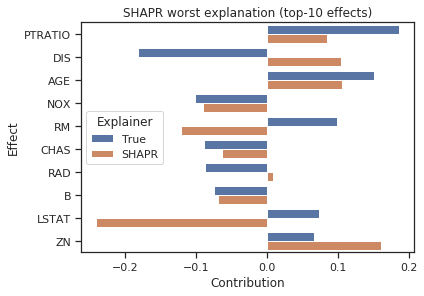

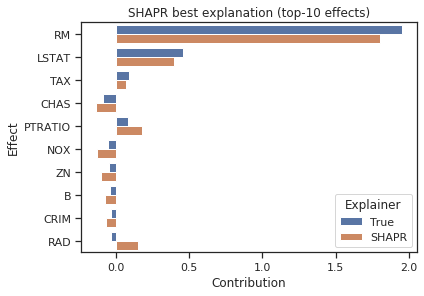

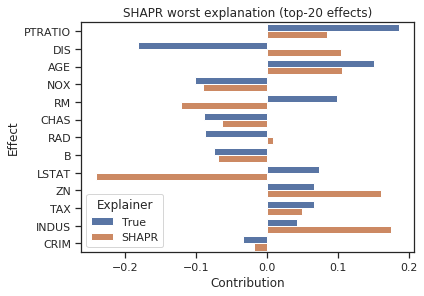

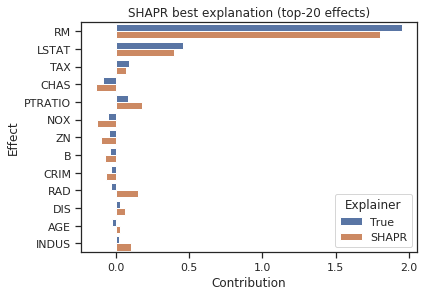

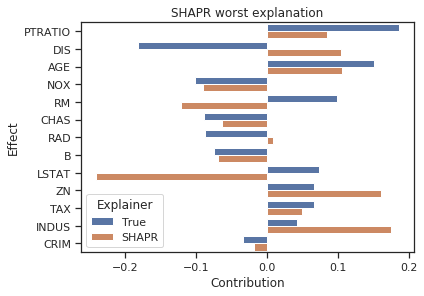

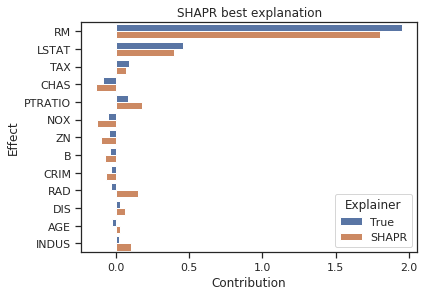

In [20]:
k = 5
worst_by = 'cosine_distances'
# worst_by = 'euclidean_distances'

# Top k worst explanations per explainer
df_effects = err_dfs['samplewise_err']
df_effects = df_effects[df_effects['Metric'] == worst_by]
for explainer_name, df_expl_effects in df_effects.groupby(['Explainer']):
    k_f = min(k, len(df_expl_effects))
    df_expl_effects = df_expl_effects.sort_values(by='Score', ascending=False)
    print(f'{explainer_name} Top-{k_f} worst explanations:')
    display(df_expl_effects.iloc[:k_f])
    print(f'{explainer_name} Top-{k_f} best explanations:')
    display(df_expl_effects.iloc[-k_f:])
    for kk_f in [5, 10, 20, len(df_expl_effects)]:
        if kk_f > len(df_expl_effects):
            continue
        tit_extra = '' if kk_f == len(df_expl_effects) else f' (top-{kk_f} effects)'
        ax = plot_explanation(df_expl_effects.iloc[0], k=kk_f)
        ax.set_title(f'{explainer_name} worst explanation{tit_extra}')
        ax = plot_explanation(df_expl_effects.iloc[-1], k=kk_f)
        ax.set_title(f'{explainer_name} best explanation{tit_extra}')
    
    if 2 <= len(input_shape) <= 3:
        if len(input_shape) == 3:
            if input_shape[2] != 1:
                print(f'{input_shape} does not have unary channels, not implemented for viz!')
                continue
            else:
                shape = input_shape[:2]
        else:
            shape = input_shape
        f = heatmap_explanation(df_expl_effects.iloc[0], shape)
        f.suptitle(f'{explainer_name} worst explanation')
        f = heatmap_explanation(df_expl_effects.iloc[-1], shape)
        f.suptitle(f'{explainer_name} best explanation')

In [21]:
y_model_subset = model.predict(X_subset)
if task == 'classification':
    acc = metrics.accuracy(y_subset, y_model_subset)
    print(f'Model accuracy={acc * 100:.2f}')
else:
    err = metrics.rmse(y_subset, y_model_subset)
    print(f'Model rmse={err:.3g}')

perfs = []
for explainer_name, y_pred_expl in pred_y_map.items():
    if y_pred_expl is None:
        print('Skipping', explainer_name, '(no predict() implementation)')
        continue
    if task == 'classification':
        metric_name = 'accuracy'
        y_pred_expl = np.argmax(y_pred_expl, axis=0)
        score = acc = metrics.accuracy(y_model_subset, y_pred_expl)
        print(f'{explainer_name} accuracy={acc * 100:.2f}')
    else:
        metric_name = 'rmse'
        score = err = metrics.rmse(y_model_subset, y_pred_expl)
        print(f'{explainer_name} rmse={err:.3g}')
    perfs.append({'Explainer': explainer_name, 'Metric': metric_name, 'Score': score})
perf_df = pd.DataFrame(perfs)

Model rmse=0.419
LIME rmse=0.252
SHAP rmse=1.08e-07
SHAPR rmse=1.23e-07
MAPLE rmse=0.243
PDP rmse=0.0129


In [24]:
# Dump all data to file for reproducing plotting etc.
import pickle
import os
from datetime import datetime

out_dir = 'real_world_results'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

now_str = datetime.now().isoformat(timespec='seconds').replace(':', '_')
out_name = f'{dataset_name}_{model_type}_{task}_{now_str}.pkl'

with open(os.path.join(out_dir, out_name), 'wb') as f:
    pickle.dump({
        'df': df,
        'df_3d': df_3d,
        'contribs_df': contribs_df,
        'err_dfs': err_dfs,
        'task': task,
        'feature_names': feature_names,
        'input_shape': input_shape,
        'n_features': n_features,
        'model_type': model_type,
        'perf_df': perf_df,
    }, f)